![](../JFM-notebooks-logo.jpg)

In [1]:
import numpy as np
import h5py
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import cmocean

# Aesthetics
sns.set_theme()
sns.set_style('ticks')
sns.set_context('paper')
plt.rc('mathtext', fontset='stix')
plt.rc('font', family='serif')

### Define consistent colours and line styles for variations in $Re$, $Gr$, and $Pr$

In [2]:
camp = sns.color_palette('flare', as_cmap=True)
cspeed = cmocean.tools.crop_by_percent(cmocean.cm.tempo, 30, which='both', N=None)

def Re_col(lR):
    return camp((lR - 2.5)/1.5)

def Gr_col(lG):
    return cspeed((lG - 6)/2)

def Pr_stl(Pr):
    if Pr==1:
        stl = '-'
    elif Pr==4:
        stl = '--'
    elif Pr==10:
        stl = ':'
    else:
        stl = '-.'
    return stl

### Average profiles using symmetry across the midplane

In [3]:
def sym_prof(v):
    n = v.size
    return 0.5*(v[:n//2] + v[-1:-n//2-1:-1])

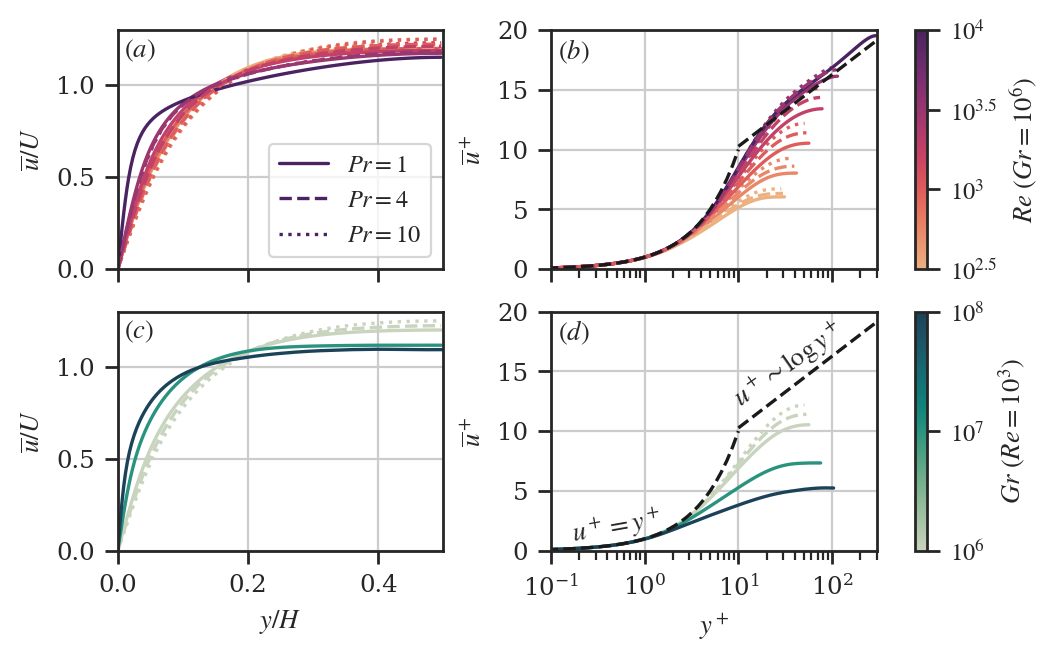

In [4]:
fig, axs = plt.subplots(2,2, figsize=(5.2,3.2), layout='constrained', dpi=200, sharex='col', sharey='col')

with h5py.File('../data/profile_record.h5','r') as fp:

    for grp in fp.__iter__():
        # Read mean profile
        x = fp[grp+'/xm'][:]
        xs = x[:x.size//2]
        vzbar = sym_prof(fp[grp+'/vzbar'][:])

        # Read control parameters (logarithms)
        lGr = int(grp[2])
        lRe = float(grp[-4:])
        lRi = lGr - 2*lRe

        # Exclude cases with no pressure gradient
        if lRe > 0:
            # Compute free-fall and bulk velocity scales
            Uf = 10**np.min([lGr/2 - lRe, 0])
            Ub = 10**np.min([lRe - lGr/2, 0])
    
            Gr = 10**lGr
            Re = 10**lRe
            Pr = int(grp[6:-7])

            # Compute dimensionless friction velocity/shear Reynolds number
            Wtau = (vzbar[0]/x[0] / np.max([Gr**0.5,Re]) )**0.5
            Retauz2 = Wtau*np.max([Gr**0.5,Re])

            # Gr=10^6 cases
            if 'Gr6' in grp:
                axs[0,0].plot(xs, vzbar/Ub, color=Re_col(lRe), linestyle=Pr_stl(Pr))
                axs[0,1].plot(xs*Retauz2, vzbar/Wtau, color=Re_col(lRe), linestyle=Pr_stl(Pr))
            # Re=10^3 cases
            if lRe==3:
                axs[1,0].plot(xs, vzbar/Ub, color=Gr_col(lGr), linestyle=Pr_stl(Pr))
                axs[1,1].plot(xs*Retauz2, vzbar/Wtau, color=Gr_col(lGr), linestyle=Pr_stl(Pr))
        
# Add theoretical comparisons
xl = 10**np.linspace(-2,1)
xh = 10**np.linspace(1,2.5)
for ax in axs[:,1]:
    ax.plot(xl, xl, 'k--')
    ax.plot(xh, 4.27 + np.log(xh)/0.384, 'k--')
    ax.semilogx()
axs[1,0].set_xlabel('$y/H$')
axs[1,0].set_xlim([0,0.5])
axs[1,0].set_ylim([0,1.3])

# Add labels
for ax in axs[:,0]:
    ax.set_ylabel('$\overline{u}/U$')
for ax in axs[:,1]:
    ax.set_ylabel(r'$\overline{u}^+$')
axs[1,1].set(
    xlabel='$y^+$',
    xlim=[1e-1,300],
    ylim=[0,20]
)

# Add standalone colorbar for Re
norm = mpl.colors.Normalize(vmin=2.5, vmax=4)
cbR = fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=camp),
             ax=axs[0,:], label='$Re\ (Gr=10^6)$')
Rlst = [2.5, 3, 3.5, 4]
cbR.set_ticks(Rlst, labels=['$10^{'+str(R)+'}$' for R in Rlst])

# Add standalone colorbar for Gr
norm = mpl.colors.Normalize(vmin=6, vmax=8)
cbG = fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cspeed),
             ax=axs[1,:], label='$Gr\ (Re=10^3)$')
Glst = [6, 7, 8]
cbG.set_ticks(Glst, labels=['$10^{'+str(G)+'}$' for G in Glst])

# Add legend
ax = axs[0,0]
Prs = [1, 4, 10]
for P in Prs:
    ax.plot(0,0, color=Re_col(4), linestyle=Pr_stl(P), label='$Pr=%i$' % P)
ax.legend()

for ax in axs.flatten():
    ax.grid(True)

lbls = ['$(a)$','$(b)$','$(c)$','$(d)$']
for i, lbl in enumerate(lbls):
    axs[i//2,i%2].annotate(lbl, (0.02, 0.97), xycoords='axes fraction', ha='left', va='top')

ax = axs[1,1]
ax.annotate('$u^+ = y^+$', (0.5,2),ha='center', va='center', rotation=10)
ax.annotate('$u^+ \sim \log y^+$', (35,15.5),ha='center', va='center', rotation=35)

# fig.savefig('u_profiles.pdf')

plt.show()